In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from sl_ai.process_videos import ffmpeg_resize, WIDTH, HEIGHT
from time import sleep
import skvideo.io
import skvideo.utils
import keras
from keras.utils import to_categorical

In [ ]:
DATASET_CUTOFF = 2  # Only select gestures where the dataset is >= DATASET_CUTOFF

lookup = dict()
reverselookup = dict()
ROOT_PATH = Path('../../ai_data/vgt-all-360')
count = 0
for j in os.listdir(ROOT_PATH):
    if not j.startswith('.') and len(os.listdir(ROOT_PATH / j)) >= DATASET_CUTOFF:
        lookup[j] = count
        reverselookup[count] = j
        count += 1
lookup

In [ ]:
reverselookup

In [ ]:
def rescale_list(input_list, size):
    # Does not work for lists shorter than size yet.
    assert len(input_list) >= size
    skip = len(input_list) // size
    output = [input_list[i] for i in range(0, len(input_list), skip)]
    return output[:size]

def read_video(file_path: str, as_grey=False):
    video_data = skvideo.io.vreader(file_path, as_grey=as_grey)
    return list(video_data)

def grayscale_video(video_data):
    # Converts video data to grayscale.
    return skvideo.utils.rgb2gray(video_data)

In [ ]:
x_data = []  # All frames in dataset.
y_data = []  # Classes/Gestures of the frames as integers.
frame_count = 0
total_videos = 0
for n, gesture in enumerate(os.listdir(ROOT_PATH)): # Loop over gestures.
    videos = os.listdir(ROOT_PATH / gesture)
    if len(videos) < DATASET_CUTOFF:
        continue

    total_videos += len(videos)
    for person_video in videos: # Loop over persons.
        count = 0
        video_data = read_video(str(ROOT_PATH / gesture / person_video))
        video_data = rescale_list(video_data, 50)
        for frame in video_data:
            x_data.append(frame)
            count += 1
        y_values = np.full((count, 1), lookup[gesture])
        y_data.append(y_values)
        frame_count += count

x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(frame_count, 1) # Res

In [ ]:
import cv2
# Image colors look distorted but this is only in the preview. The raw data is still correct.
for i in range(0, len(lookup)):
    img_data = x_data[i*50 + 25 , :, :]
    img_data = img_data.astype(np.uint8)
    plt.imshow(img_data)
    plt.title(reverselookup[y_data[i*50+25 , 0]])
    plt.show()

In [ ]:
y_data_cat = to_categorical(y_data)
y_data_cat

In [ ]:
x_data2 = x_data.reshape((frame_count, 360, 640, 3))
x_data2 /= 255

In [ ]:
from sklearn.model_selection import train_test_split
# TODO: THIS IS BAD!!!. A gesture can be split in two by the split function !!!
# TODO: Split the data manually.

x_train,x_further,y_train,y_further = train_test_split(x_data2, y_data_cat, test_size = .1)
# Split further vor validation data. Skip this now since the dataset is too small to split further.
# x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further, test_size = 0.5)
print(len(x_data2))
print(len(x_train))
print(len(x_further))
print(len(y_train))
print(len(y_further))

In [ ]:
from keras import layers
from keras import models
model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(360, 640, 3), name='Conv2D_1'))
model.add(layers.MaxPooling2D((2, 2), name='MaxPooling2D_1'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='Conv2D_2'))
model.add(layers.MaxPooling2D((2, 2), name='MaxPooling2D_2'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='Conv2D_3'))
model.add(layers.MaxPooling2D((2, 2), name='MaxPooling2D_3'))
model.add(layers.Flatten(name='Flatten'))
model.add(layers.Dense(128, activation='relu', name='Dense_1'))
model.add(layers.Dense(len(lookup), activation='softmax', name='Dense_2'))

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# history = model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(x_validate, y_validate))

history = model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1)

In [ ]:
# Used when trained with validation data.
# [loss, acc] = model.evaluate(x_test,y_test,verbose=1)

[loss, acc] = model.evaluate(x_further,y_further,verbose=1)
print("Accuracy:" + str(acc))

In [ ]:
model.summary()

In [ ]:
# Will give an exception if training was done without validation data. This can be ignored.
def visualize_accuracy():
    """Visualize model accuracy
    """
    if history:
        plt.plot(history.history['accuracy'], label='training accuracy')
        plt.plot(history.history['val_accuracy'], label='testing accuracy')
        plt.title('Accuracy')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.legend()

def visualize_loss():
    """Visualizes model loss"""
    if history:
        plt.plot(history.history['loss'], label='training loss')
        plt.plot(history.history['val_loss'], label='testing loss')
        plt.title('Loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()

In [ ]:
visualize_accuracy()

In [ ]:
visualize_loss()

In [ ]:
model.save('vgt_v1.h5')

In [ ]:
# Should refer to a video NOT part of trained data. Ideally a video from your webcam.
# IMPORTANT: This video needs to be 640x360 resolution and without audio.
# If you have FFMPEG installed a video can be converted using the following command.
#   ffmpeg -y -i <INPUT> -an -vf scale=640:360 -c:v h264 <OUTPUT>
# -ss and -to can be used to trim parts of the video.
#   ffmpeg -y -ss 2 -to 6.2 -i <INPUT> -an -vf scale=640:360 -c:v h264 <OUTPUT>
# change to scale=640:360,hflip to mirror recording.

# input_video = Path(r'../ai_data\vgt-test-360\land - verenigde staten\VERENIGDE-STATEN.mp4')
input_video = Path(r'../../ai_data/camera_recordings/usa.mp4')
video_data = np.array(
    rescale_list(
        read_video(str(input_video)),
        50),
    dtype = 'float32')

for i in range(0, 50, 10):
    frame = video_data[i , :, :]
    frame = frame.astype(np.uint8)
    plt.imshow(frame)
    plt.show()

video_data /= 255

In [ ]:
prediction = model.predict(video_data)
classes_x = np.argmax(prediction, axis=1)
print(classes_x)
print('Prediction per frame:')
for i, frame in enumerate(video_data):
    print(f"Frame {i}:", reverselookup[classes_x[i]])
print("----------"*5)
most_common_prediction = np.bincount(classes_x[10:-10]).argmax()
print(f'Predicted that {input_video.name} is gesture "{reverselookup[most_common_prediction]}"')

### Manually analyze the prediction
Columns are classes/gestures, rows are each frame of the video. Values are expressed as percentages.

In [ ]:
import pandas as pd
from pprint import pprint
# pprint(reverselookup)
prediction_percents = (prediction*100)
# prediction_percents[prediction_percents < 5] = None
pd.DataFrame(prediction_percents.astype(np.uint8), columns=reverselookup.values())

Quickly see a preview of a frame at the specified index.

In [ ]:
frame_to_preview = 35
frame = video_data[frame_to_preview , :, :]
frame *= 255
frame = frame.astype(np.uint8)
plt.imshow(frame)
plt.show()

In [34]:
prediction_percents = (prediction*100)
pd.DataFrame(prediction_percents.astype(np.uint8), columns=reverselookup.values())

,sport - bowlen,sport - fietsen,technologie - computer,land - verenigde staten,land - belgie,communicatie - gebaar,communicatie - hallo,communicatie - duidelijk,dier - geit
0,0,0,0,90,0,9,0,0,0
1,0,0,0,86,0,13,0,0,0
2,0,0,1,70,0,27,0,0,0
3,0,0,2,50,0,46,0,0,0
4,0,0,2,44,0,52,0,0,0
5,0,0,2,41,0,55,0,0,0
6,0,0,2,41,0,56,0,0,0
7,0,0,2,39,0,57,0,0,0
8,0,0,2,37,0,59,0,0,0
9,0,0,1,44,0,53,0,0,0


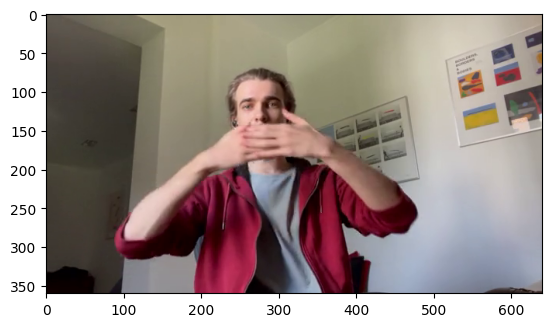

In [71]:
frame_to_preview = 35
frame = video_data[frame_to_preview , :, :]
frame *= 255
frame = frame.astype(np.uint8)
plt.imshow(frame)
plt.show()

In [ ]:
prediction_percents = (prediction*100)
pd.DataFrame(prediction_percents.astype(np.uint8), columns=reverselookup.values())